In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nltk

# Lenguaje Claro - UPE
Lucas Pecina

09/01/21

---
### Objetivo
Comparar distintos textos (legales, judiciales, etc) para ver la complejidad que tiene ese texto en cuanto a palabras dificiles (poco frecuentes en el lenguaje cotidiano).

### Resumen
El lenguaje legal/judicial suele ser complicado de entender para la gente que no se dedica a temas relacionados debido a la complejidad de las palabras utilizadas y de su gramatica. El analisis de complejidad gramatical de los textos requiere la utilizacion de tecnicas muy sofisticadas y que no dan buenos resultados, por lo tanto, descartamos este tipo de estudio por el momento.

Comenzamos solo analizando las **palabras** de los textos y creamos un **indice de complejidad** que mide la cantidad y frecuencia de palabras "complejas", que son de poca frecuencia en el lenguaje cotidiano. 

No contaran para el calculo aquellas palabras que por su naturaleza tecnica juridica requiera de su uso obligatorio. Para dicha tarea, se elaborara a mano una lista de las palabras en cuestion.

### Fuentes de datos
- Textos a analizar: seran cargados como archivos de texto
 - Codigo Procesal Civil y Comercial actual http://biblioteca.asesoria.gba.gov.ar/redirect.php?id=2121 esta en un archivo CPCC
 - Codigo Procesal Penal actual http://servicios.infoleg.gob.ar/infolegInternet/anexos/0-4999/383/texact.htm 
- Bolsa de palabras de frecuencia del lenguaje español http://corpus.rae.es/lfrecuencias.html. Usando las 300mil palabras mas frecuentes del español: en datos/

### Pasos
1. Corpus de palabras frecuentes
 - Armar dataframe con frecuencias
 - Calcular complejidad de palabras
2. Cargar textos y preprocesarlo
 - Tokenizar las palabras
 - Limpiar errores
 - Remover stopwords


---
### Indice de complejidad del lenguaje
$$Complejidad_t = \frac{1}{P}\sum_p^P{Complejidad_p}$$

- t = texto a analizar
- p = lista de palabras en el texto t (pueden estar repetidas)
- P = cantidad de palabras en el texto t (todas)

$$Complejidad_p = f(FrecuenciaBolsa_p)$$

$$Complejidad_p = \frac{1}{FrecuenciaBolsa_p}$$


Corpus de palabras frecuentes del español
---



In [2]:
# cargo datos
corpus = pd.read_excel('/Users/lucaspecina/Desktop/Data/Planificacion Estrategica/lenguaje-claro/upe-lenguaje_claro/datos/CREA_total.xlsx')
corpus = corpus.dropna()
corpus['Palabra'] = corpus.Palabra.astype('str').str.strip()
corpus = corpus[corpus.Frecuencia_norm>0.00]

# reemplazo caracteres mal cargados
reemplazar = {'·':'á','È':'é','Ò':'ñ','˙':'ú','¸':'ü','Ì':'í','Û':'ó'}

for k,v in reemplazar.items():
    corpus['Palabra'] = corpus.Palabra.str.replace(k,v)
corpus

,Orden,Palabra,Frecuencia,Frecuencia_norm
0,1,de,9999518,65545.55
1,2,la,6277560,41148.59
2,3,que,4681839,30688.85
3,4,el,4569652,29953.48
4,5,en,4234281,27755.16
...,...,...,...,...
423729,423730,zyscovich,2,0.01
423730,423731,zyx,2,0.01
423731,423732,zzz,2,0.01
423732,423733,zzzzzzzzzzz,2,0.01


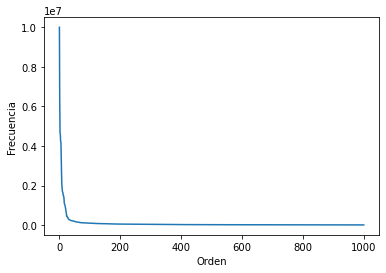

In [29]:
sns.lineplot(x=corpus.iloc[:1000,:].Orden, y=corpus.iloc[:1000,:].Frecuencia)

In [3]:
corpus.Frecuencia_norm.sum()

995706.050000001

In [4]:
# calculo complejidad
corpus['complejidad'] = 1/corpus.Frecuencia_norm
corpus

,Orden,Palabra,Frecuencia,Frecuencia_norm,complejidad
0,1,de,9999518,65545.55,0.000015
1,2,la,6277560,41148.59,0.000024
2,3,que,4681839,30688.85,0.000033
3,4,el,4569652,29953.48,0.000033
4,5,en,4234281,27755.16,0.000036
...,...,...,...,...,...
423729,423730,zyscovich,2,0.01,100.000000
423730,423731,zyx,2,0.01,100.000000
423731,423732,zzz,2,0.01,100.000000
423732,423733,zzzzzzzzzzz,2,0.01,100.000000


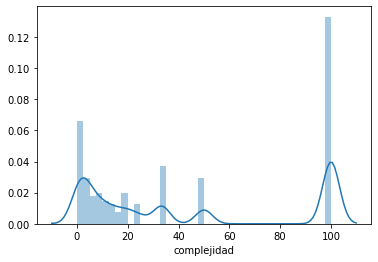

In [5]:
sns.distplot(corpus.complejidad)

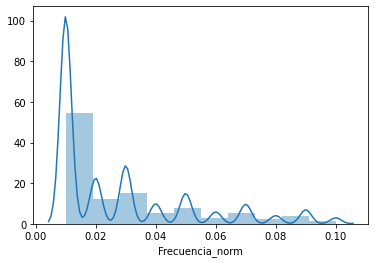

In [6]:
sns.distplot(corpus[(corpus.Frecuencia_norm<=0.1)].Frecuencia_norm, bins=10)

Procesamiento de textos a analizar
---


In [7]:
# funcion para el preprocesamiento de los textos a cargar

def limpieza_textos(raw,corpus):
    tokens = nltk.word_tokenize(raw)
    tokens = [t.lower() for t in tokens if t.isalpha()]
    print(f'El texto original tiene {len(tokens)} palabras.')
    print(f'De esas, hay {len(np.unique(np.array(tokens)))} unicas')
    
    # hay muchos que finalizan en "are", 'ere'. Mencionare, juzgare, interpusiere, etc.
    # a esos los saco
    tokens = [t for t in tokens if ('are' not in t) & ('ere' not in t)]
    print(f'Despues de sacarle las palabras que terminan en ARE o ERE, quedan {len(tokens)} palabras.')
    print(f'Ahora hay {len(np.unique(np.array(tokens)))} unicas')
    
    # veo las palabras del texto que no estan en el corpus y las agrego al corpus para que cuenten
    no_estan = [t for t in np.unique(np.array(tokens)) if t not in corpus.Palabra.values]
    print(f'Hay {len(no_estan)} parabras unicas que no aparecen en el corpus. Las agrego con 100 de complejidad')
    
    # ahora quedaron solo las que son muy raras o las que estan sin tildes por los titulos
    '''Ahora hay que agregar todas estas palabras al df de corpus y agregarle
    el valor maximo = 100 '''

    no_estan_df = pd.DataFrame({'Palabra':no_estan, 'complejidad':[100.0]*len(no_estan)})
    print('no estan df')
    print(no_estan_df)
    # concat
    corpus_ag = pd.concat([corpus[['Palabra','complejidad']],no_estan_df]).reset_index()
    
    return(tokens,corpus_ag)    

In [8]:
# funcion para calcular frecuencias de palabras en texto y calculo el indice_complejidad

def crear_indice_complejidad(tokens,corpus,nombre_texto,comunes_sacar):
    '''1 crear df de palabras de nombre_texto y las frecuencias
       2 joinear y calcular'''

    tokens_freq = pd.DataFrame.from_dict(nltk.FreqDist(tokens), orient='index').reset_index()
    tokens_freq.columns = ['Palabra','freq']

    print('tokens_freq')
    print(tokens_freq)
    
    # joinear
    tokens_complejidad = corpus.iloc[comunes_sacar:,:].merge(tokens_freq, left_on='Palabra',right_on='Palabra').reset_index(drop=True)
    # outer joinear pero para ver los que no estan
    no_estan = corpus.iloc[comunes_sacar:,:].merge(tokens_freq, on=['Palabra','Palabra'], how='right', indicator=True).reset_index()
    no_estan = no_estan[no_estan['_merge'] == 'right_only']
    
    # calculo indice_complejidad
    tokens_complejidad['indice_complejidad'] = (tokens_complejidad.complejidad * tokens_complejidad.freq)/tokens_complejidad.freq.sum()
    print(f'la cantidad de palabras que coincidieron en el corpus es de {len(tokens_complejidad)}')
    
    indice_complejidad = round(sum(tokens_complejidad.indice_complejidad),5)
    print(f'INDICE DE COMPLEJIDAD DE {nombre_texto}: {indice_complejidad}')
    
    return(tokens_complejidad, indice_complejidad, no_estan)

In [9]:
# funcion para el preprocesamiento de los textos a cargar

def limpieza_textos_simple(raw, sacar_ere_ese=False):
    '''Considera como errores/cosas extremas a las palabras que estan
    en el texto pero no en el corpus'''
    tokens = nltk.word_tokenize(raw)
    tokens = [t.lower() for t in tokens if t.isalpha()]
    
    if sacar_ere_ese:
        # saco a los que finalizan en "are", 'ere'. Mencionare, juzgare, interpusiere, etc.
        tokens = [t for t in tokens if ('are' not in t) & ('ere' not in t)]
        print('Luego de sacar las que tienen ARE o ERE (como conociere)')
    
    print(f'El texto original tiene {len(tokens)} palabras.')
    print(f'De esas, hay {len(np.unique(np.array(tokens)))} unicas')

    return(tokens)

In [10]:
comunes_sacar = 0
sacar_ere_ese = False

CPCC
---

In [11]:
cpcc_f = open('/Users/lucaspecina/Desktop/Data/Planificacion Estrategica/lenguaje-claro/upe-lenguaje_claro/datos/CPCC.txt')
cpcc_raw = cpcc_f.read()
cpcc_tokens = limpieza_textos_simple(cpcc_raw, sacar_ere_ese)
cpcc_tokens, cpcc_indice, cpcc_no_estan = crear_indice_complejidad(cpcc_tokens,corpus,'CPCC actual',comunes_sacar)
cpcc_tokens.sort_values('indice_complejidad',ascending=False).head(10)

El texto original tiene 62785 palabras.
De esas, hay 5627 unicas
tokens_freq
            Palabra  freq
0             libro    23
1                 i    32
2     disposiciones    45
3         generales    16
4            título    70
...             ...   ...
5622       cúmplase     1
5623    comuníquese     1
5624     publíquese     1
5625           dese     1
5626      archívese     1

[5627 rows x 2 columns]
la cantidad de palabras que coincidieron en el corpus es de 5359
INDICE DE COMPLEJIDAD DE CPCC actual: 0.81736


,Orden,Palabra,Frecuencia,Frecuencia_norm,complejidad,freq,indice_complejidad
5210,258917,correspondiere,4,0.02,50.0,27,0.021669
5303,350809,compareciere,2,0.01,100.0,13,0.020866
5257,297261,devolutivo,3,0.01,100.0,13,0.020866
5202,253597,apelable,4,0.02,50.0,23,0.018459
5232,267522,irrecurrible,4,0.02,50.0,13,0.010433
5273,310387,litispendencia,3,0.01,100.0,6,0.009631
5294,332839,admitiere,2,0.01,100.0,6,0.009631
5203,253598,apelante,4,0.02,50.0,10,0.008026
5336,392124,notificador,2,0.01,100.0,5,0.008026
5259,297747,dispusiere,3,0.01,100.0,5,0.008026


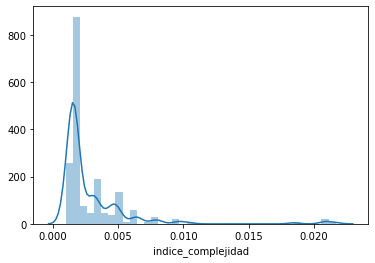

In [12]:
# a ver como es la forma de la distribucion de indice de complejidad por palabra

sns.distplot(cpcc_tokens[cpcc_tokens.indice_complejidad>0.001].indice_complejidad)

In [13]:
cpcc_no_estan.head(25)

,index,Orden,Palabra,Frecuencia,Frecuencia_norm,complejidad,freq,_merge
5359,5359,NaN,exceptúase,NaN,NaN,NaN,3,right_only
5360,5360,NaN,surgiere,NaN,NaN,NaN,1,right_only
5361,5361,NaN,opusiere,NaN,NaN,NaN,6,right_only
5362,5362,NaN,indelegabilidad,NaN,NaN,NaN,1,right_only
5363,5363,NaN,versare,NaN,NaN,NaN,1,right_only
5364,5364,NaN,protocolizaron,NaN,NaN,NaN,1,right_only
5365,5365,NaN,durare,NaN,NaN,NaN,1,right_only
5366,5366,NaN,substanciará,NaN,NaN,NaN,4,right_only
5367,5367,NaN,remitiere,NaN,NaN,NaN,2,right_only
5368,5368,NaN,intimará,NaN,NaN,NaN,6,right_only


In [14]:
# GUARDAR RESULTADOS EN RESULTADOS COMPLEMENTARIOS

# cpcc_tokens.to_excel('/Users/lucaspecina/Desktop/Data/Planificacion Estrategica/lenguaje-claro/resultados complementarios/CPCC_actual_indice_palabras.xlsx')
# cpcc_no_estan.to_excel('/Users/lucaspecina/Desktop/Data/Planificacion Estrategica/lenguaje-claro/resultados complementarios/CPCC_actual_palabras_no_estan_corpus.xlsx')


CPCC NUEVO
---

In [15]:
cpcc_nuevo_f = open('/Users/lucaspecina/Desktop/Data/Planificacion Estrategica/lenguaje-claro/upe-lenguaje_claro/datos/CPCC_nuevo.txt')
cpcc_nuevo_raw = cpcc_nuevo_f.read()
cpcc_nuevo_tokens = limpieza_textos_simple(cpcc_nuevo_raw, sacar_ere_ese)
cpcc_nuevo_tokens, cpcc_nuevo_indice, cpcc_nuevo_no_estan = crear_indice_complejidad(cpcc_nuevo_tokens,corpus,'CPCC nuuvo',comunes_sacar)
cpcc_nuevo_tokens.sort_values('indice_complejidad',ascending=False).head(30)

El texto original tiene 29945 palabras.
De esas, hay 3797 unicas
tokens_freq
            Palabra  freq
0                el   817
1            senado     1
2                 y   776
3            cámara    26
4                de  2053
...             ...   ...
3792  anteriormente     1
3793       eficacia     1
3794      anticipar     1
3795   reconvención     1
3796     justifican     1

[3797 rows x 2 columns]
la cantidad de palabras que coincidieron en el corpus es de 3755
INDICE DE COMPLEJIDAD DE CPCC nuuvo: 0.42397


,Orden,Palabra,Frecuencia,Frecuencia_norm,complejidad,freq,indice_complejidad
3726,253597,apelable,4,0.02,50.000000,11,0.018409
3708,224369,poderdante,6,0.03,33.333333,13,0.014504
3729,267522,irrecurrible,4,0.02,50.000000,8,0.013389
3744,326978,tercerías,3,0.01,100.000000,4,0.013389
3712,237599,excusación,5,0.03,33.333333,11,0.012273
3594,121542,juezas,21,0.13,7.692308,37,0.009527
3732,274916,procuradoras,4,0.02,50.000000,4,0.006694
3743,325660,subalternización,3,0.01,100.000000,2,0.006694
3727,253665,apoderadas,4,0.02,50.000000,4,0.006694
3539,101016,actora,30,0.19,5.263158,33,0.005814


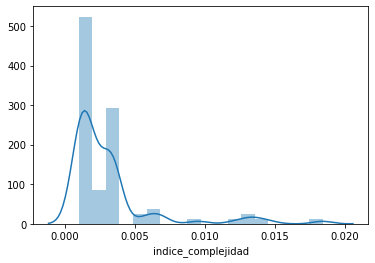

In [16]:
# a ver como es la forma de la distribucion de indice de complejidad por palabra

sns.distplot(cpcc_nuevo_tokens[cpcc_nuevo_tokens.indice_complejidad>0.001].indice_complejidad)

In [17]:
cpcc_nuevo_no_estan

,index,Orden,Palabra,Frecuencia,Frecuencia_norm,complejidad,freq,_merge
3755,3755,NaN,morigerarse,NaN,NaN,NaN,1,right_only
3756,3756,NaN,monitorias,NaN,NaN,NaN,1,right_only
3757,3757,NaN,protectoria,NaN,NaN,NaN,1,right_only
3758,3758,NaN,ordenatoria,NaN,NaN,NaN,2,right_only
3759,3759,NaN,revictimización,NaN,NaN,NaN,1,right_only
3760,3760,NaN,eﬁciencia,NaN,NaN,NaN,1,right_only
3761,3761,NaN,eﬁcacia,NaN,NaN,NaN,1,right_only
3762,3762,NaN,análogicos,NaN,NaN,NaN,1,right_only
3763,3763,NaN,justiciabilidad,NaN,NaN,NaN,1,right_only
3764,3764,NaN,subalternizados,NaN,NaN,NaN,3,right_only


In [18]:
# GUARDAR RESULTADOS EN RESULTADOS COMPLEMENTARIOS

# cpcc_nuevo_tokens.to_excel('/Users/lucaspecina/Desktop/Data/Planificacion Estrategica/lenguaje-claro/resultados complementarios/CPCC_nuevo_indice_palabras.xlsx')
# cpcc_nuevo_no_estan.to_excel('/Users/lucaspecina/Desktop/Data/Planificacion Estrategica/lenguaje-claro/resultados complementarios/CPCC_nuevo_palabras_no_estan_corpus.xlsx')


CPP
---

In [19]:
cpp_f = open('/Users/lucaspecina/Desktop/Data/Planificacion Estrategica/lenguaje-claro/upe-lenguaje_claro/datos/CPP.txt')
cpp_raw = cpp_f.read()

cpp_tokens = limpieza_textos_simple(cpp_raw, sacar_ere_ese)
cpp_tokens, cpp_indice, cpp_no_estan = crear_indice_complejidad(cpp_tokens,corpus,'CPP actual',comunes_sacar)
cpp_tokens.sort_values('indice_complejidad',ascending=False).head(10)

El texto original tiene 44432 palabras.
De esas, hay 4445 unicas
tokens_freq
           Palabra  freq
0           codigo    11
1         procesal    29
2            penal   101
3              ley   163
4              ver     2
...            ...   ...
4440  permanecerán     1
4441       entrará     1
4442     efectuada     1
4443       reforma     1
4444       órganos     1

[4445 rows x 2 columns]
la cantidad de palabras que coincidieron en el corpus es de 4357
INDICE DE COMPLEJIDAD DE CPP actual: 0.47422


,Orden,Palabra,Frecuencia,Frecuencia_norm,complejidad,freq,indice_complejidad
4340,381324,labrará,2,0.01,100.000000,7,0.015797
4329,326089,supiere,3,0.01,100.000000,7,0.015797
4285,253597,apelable,4,0.02,50.000000,11,0.012412
4336,350809,compareciere,2,0.01,100.000000,4,0.009027
4303,267522,irrecurrible,4,0.02,50.000000,7,0.007899
4292,258917,correspondiere,4,0.02,50.000000,7,0.007899
4349,401415,quáter,2,0.01,100.000000,3,0.006770
4334,332839,admitiere,2,0.01,100.000000,3,0.006770
4274,237599,excusación,5,0.03,33.333333,8,0.006018
4253,217807,encontrare,6,0.03,33.333333,7,0.005266


Comparacion
---

In [20]:
print(f'La tasa de complejidad de uno sobre el otro es de: \n{round(cpcc_indice/cpp_indice, 2)} ({round((cpcc_indice-cpp_indice)/cpp_indice*100, 1)}% mas complejo)')

La tasa de complejidad de uno sobre el otro es de: 
1.72 (72.4% mas complejo)


Prueba borges
---


In [21]:
borges_f = open('/Users/lucaspecina/Desktop/Data/Planificacion Estrategica/lenguaje-claro/upe-lenguaje_claro/datos/borges-senderos.txt')
borges_raw = borges_f.read()

borges_tokens = limpieza_textos_simple(borges_raw, sacar_ere_ese)
borges_tokens, borges_indice, borges_no_estan = crear_indice_complejidad(borges_tokens,corpus,'borges',comunes_sacar)
borges_tokens.sort_values('indice_complejidad',ascending=False).head(10)

El texto original tiene 3650 palabras.
De esas, hay 1310 unicas
tokens_freq
          Palabra  freq
0              en   102
1              la   132
2          página     3
3              de   215
4        historia     2
...           ...   ...
1305    estrépito     1
1306        hallé     1
1307        saber     1
1308  innumerable     1
1309   contrición     1

[1310 rows x 2 columns]
la cantidad de palabras que coincidieron en el corpus es de 1293
INDICE DE COMPLEJIDAD DE borges: 0.62843


,Orden,Palabra,Frecuencia,Frecuencia_norm,complejidad,freq,indice_complejidad
1292,392684,ochavados,2,0.01,100.000000,1,0.027663
1283,268983,lidell,4,0.02,50.000000,2,0.027663
1291,331837,acaballado,2,0.01,100.000000,1,0.027663
1290,327297,tientsin,3,0.01,100.000000,1,0.027663
1289,299383,enclaustró,3,0.01,100.000000,1,0.027663
1288,292955,coalescentes,3,0.01,100.000000,1,0.027663
1286,281038,tsun,4,0.02,50.000000,2,0.027663
1270,195314,porvenires,8,0.05,20.000000,4,0.022130
1244,107467,madden,27,0.17,5.882353,11,0.017899
1267,178162,argüí,9,0.05,20.000000,3,0.016598


Corazon delator - Poe
---

In [22]:
poe_f = open('/Users/lucaspecina/Desktop/Data/Planificacion Estrategica/lenguaje-claro/upe-lenguaje_claro/datos/corazon-delator.txt')
poe_raw = poe_f.read()

poe_tokens = limpieza_textos_simple(poe_raw, sacar_ere_ese)
poe_tokens, poe_indice, poe_no_estan = crear_indice_complejidad(poe_tokens,corpus,'poe - corazon delator',comunes_sacar)
poe_tokens.sort_values('indice_complejidad',ascending=False).head(10)

El texto original tiene 2059 palabras.
De esas, hay 744 unicas
tokens_freq
      Palabra  freq
0      cierto     1
1     siempre     3
2          he     3
3        sido     3
4    nervioso     4
..        ...   ...
739      otra     1
740    fingir     1
741  malvados     1
742      maté     1
743      esos     1

[744 rows x 2 columns]
la cantidad de palabras que coincidieron en el corpus es de 741
INDICE DE COMPLEJIDAD DE poe - corazon delator: 0.28718


,Orden,Palabra,Frecuencia,Frecuencia_norm,complejidad,freq,indice_complejidad
740,411080,sobrepujaba,2,0.01,100.000000,1,0.048638
739,323994,sentáronse,3,0.01,100.000000,1,0.048638
738,275700,raspé,4,0.02,50.000000,1,0.024319
737,248504,sobresaltara,5,0.03,33.333333,1,0.016213
736,236774,enfurecerme,5,0.03,33.333333,1,0.016213
735,164219,descansaran,11,0.07,14.285714,1,0.006948
734,163814,conduciéndolos,11,0.07,14.285714,1,0.006948
733,152435,erradamente,13,0.08,12.500000,1,0.006080
727,97564,revisaran,33,0.21,4.761905,2,0.004632
732,121482,insignificancias,21,0.13,7.692308,1,0.003741


Juli libro
---

In [23]:
juli_f = open('/Users/lucaspecina/Desktop/Data/Planificacion Estrategica/lenguaje-claro/upe-lenguaje_claro/datos/juli.txt')
juli_raw = juli_f.read()

juli_tokens = limpieza_textos_simple(juli_raw, sacar_ere_ese)
juli_tokens, juli_indice, juli_no_estan = crear_indice_complejidad(juli_tokens,corpus,'juli',comunes_sacar)
juli_tokens.sort_values('indice_complejidad',ascending=False).head(10)

El texto original tiene 2270 palabras.
De esas, hay 828 unicas
tokens_freq
        Palabra  freq
0    nuevamente     1
1            la    50
2        visión     4
3            se    42
4       evaporó     1
..          ...   ...
823   desganada     1
824      volver     1
825      corrió     1
826        tras     1
827   detenerla     1

[828 rows x 2 columns]
la cantidad de palabras que coincidieron en el corpus es de 815
INDICE DE COMPLEJIDAD DE juli: 0.39397


,Orden,Palabra,Frecuencia,Frecuencia_norm,complejidad,freq,indice_complejidad
814,340167,avior,2,0.01,100.000000,1,0.044964
813,284909,alucinador,3,0.01,100.000000,1,0.044964
773,67029,desmond,66,0.43,2.325581,24,0.025096
812,257028,causaste,4,0.02,50.000000,1,0.022482
806,198236,abraxas,7,0.04,25.000000,2,0.022482
802,159721,marcellus,12,0.07,14.285714,3,0.019270
811,229107,acechándolo,5,0.03,33.333333,1,0.014988
809,208570,provocarte,7,0.04,25.000000,1,0.011241
807,199324,asesinaste,7,0.04,25.000000,1,0.011241
810,209706,sauro,7,0.04,25.000000,1,0.011241


In [24]:
juli_no_estan

,index,Orden,Palabra,Frecuencia,Frecuencia_norm,complejidad,freq,_merge
815,815,NaN,revolt,NaN,NaN,NaN,3,right_only
816,816,NaN,servello,NaN,NaN,NaN,11,right_only
817,817,NaN,parlam,NaN,NaN,NaN,1,right_only
818,818,NaN,astrav,NaN,NaN,NaN,1,right_only
819,819,NaN,azha,NaN,NaN,NaN,2,right_only
820,820,NaN,reinad,NaN,NaN,NaN,1,right_only
821,821,NaN,mourgatz,NaN,NaN,NaN,4,right_only
822,822,NaN,interesaste,NaN,NaN,NaN,1,right_only
823,823,NaN,cromiris,NaN,NaN,NaN,3,right_only
824,824,NaN,zoá,NaN,NaN,NaN,16,right_only
